In [1]:
import cv2
import numpy as np
import time
from IPython import display
from matplotlib import pyplot as plt

class TennisBallDetector:
    def __init__(self, camera_index = 0, lower_color=(20, 100, 100), upper_color=(40, 255, 255), min_radius=10, max_radius=50, min_area=100, line_distance=100):
        self.camera_index = camera_index  # Adjust if necessary
        self.camera = None 
        self.height = None # frame wifth
        self.width = None # frame height
        self.lower_color = np.array(lower_color)
        self.upper_color = np.array(upper_color)
        self.min_radius = min_radius
        self.max_radius = max_radius
        self.min_area = min_area
        self.balls = []
        self.frame_center = None
        self.last_scanned_time = None
        self.kernel = np.ones((5, 5), np.uint8)
        self.line_distance = line_distance
        self.frame = None
        
        # Define multiple color ranges for different lighting conditions
        self.color_ranges = [
            (np.array([20, 40, 80]), np.array([80, 255, 255])),  # Yellow-green
            (np.array([15, 30, 70]), np.array([85, 255, 255])),  # Broader range
            (np.array([0, 0, 200]), np.array([180, 30, 255]))    # White range
        ]
        
        # Create background subtractor
        self.bg_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=True)

#         if not self.camera.isOpened():
#             print("Error: Could not open USB camera.")

    def detect(self, retry=True, max_num_retries=10, retry_interval=1):
        counter = 0
        
        while True:
            
            if not self.camera:
                self.camera = cv2.VideoCapture(self.camera_index)
                self.height = self.camera.get(cv2.CAP_PROP_FRAME_HEIGHT)
                self.width = self.camera.get(cv2.CAP_PROP_FRAME_WIDTH)
    
            ret, self.frame = self.camera.read()
            if not ret:
                print("Error: Failed to capture image.")
                if not retry or counter >= max_num_retries:
                    self.camera.release()
                    cv2.destroyAllWindows()
                    self.camera = None
                    return False
                counter += 1
                time.sleep(retry_interval)
                continue
    
            self.last_scanned_time = time.time()
            self.frame_center = (self.frame.shape[1] // 2, self.frame.shape[0] // 2)
    
            # Apply a slight Gaussian blur to reduce noise
            blurred_frame = cv2.GaussianBlur(self.frame, (5, 5), 0)

            # Convert the frame to the HSV color space
            hsv = cv2.cvtColor(blurred_frame, cv2.COLOR_BGR2HSV)

            # Create a mask for the tennis ball color (combine multiple ranges)
            mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
            for lower, upper in self.color_ranges:
                mask |= cv2.inRange(hsv, lower, upper)

            # Apply background subtraction
            fg_mask = self.bg_subtractor.apply(self.frame)
            
            # Combine color mask with foreground mask
            combined_mask = cv2.bitwise_and(mask, fg_mask)

            # Perform morphological operations to remove noise and improve detection
            combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, self.kernel)
            combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, self.kernel)

            # Find contours
            contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            self.balls = []

            for contour in contours:
                area = cv2.contourArea(contour)
                if area > self.min_area:
                    perimeter = cv2.arcLength(contour, True)
                    circularity = 4 * np.pi * (area / (perimeter ** 2))
                    if circularity > 0.7:  # Enforce circularity check
                        (x, y), radius = cv2.minEnclosingCircle(contour)
                        if self.min_radius < radius < self.max_radius:
                            self.balls.append(((int(x), int(y)), int(radius)))
            
            if self.balls:
                self.camera.release()
                cv2.destroyAllWindows()
                self.camera = None

                return True
            
            if not retry or counter >= max_num_retries:
                self.camera.release()
                cv2.destroyAllWindows()
                self.camera = None
                
                return False
            
            counter += 1
            time.sleep(retry_interval)

    def get_ball_count(self):
        return len(self.balls)

    def get_ball_locations(self):
        return [ball[0] for ball in self.balls]

    def get_ball_distance_from_center(self, ball_index):
        if 0 <= ball_index < len(self.balls):
            ball_center = self.balls[ball_index][0]
            dx = ball_center[0] - self.frame_center[0]
            dy = ball_center[1] - self.frame_center[1]
            distance_pixels = np.sqrt(dx**2 + dy**2)
            angle_radians = np.arctan2(dy, dx)
            return distance_pixels, angle_radians
        else:
            return None

    def get_ball_vertical_y(self, ball_index):
        if 0 <= ball_index < len(self.balls):
            return self.balls[ball_index][0][1]
        else:
            return None
        
    def draw_balls(self, frame=None):
        if frame is None:
            frame = self.frame
        for i, (center, radius) in enumerate(self.balls):
            color = (0, 255, 0) if i == 0 else (0, 255, 255)  # Green for largest, Yellow for others
            cv2.circle(frame, center, radius, color, 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)
        return frame

    def get_last_scanned_time(self):
        return self.last_scanned_time

    def draw_vertical_lines(self, frame=None):
        if frame is None:
            frame = self.frame
        height, width = frame.shape[:2]
        left_x = width // 2 - self.line_distance // 2
        right_x = width // 2 + self.line_distance // 2
        
        cv2.line(frame, (left_x, 0), (left_x, height), (255, 0, 0), 2)
        cv2.line(frame, (right_x, 0), (right_x, height), (255, 0, 0), 2)
        
        return frame

    def is_ball_between_lines(self, ball_index=0):
        if 0 <= ball_index < len(self.balls):
            ball_center, ball_radius = self.balls[ball_index]
#             height, width = self.camera.get(cv2.CAP_PROP_FRAME_HEIGHT), self.camera.get(cv2.CAP_PROP_FRAME_WIDTH)
            height, width = self.height, self.width
            left_x = width // 2 - self.line_distance // 2
            right_x = width // 2 + self.line_distance // 2
            
            return (left_x <= ball_center[0] - ball_radius) and (ball_center[0] + ball_radius <= right_x)
        else:
            return False

    def get_ball_distance_from_lines(self, ball_index=0):
        if 0 <= ball_index < len(self.balls):
            ball_center, _ = self.balls[ball_index]
#             height, width = self.camera.get(cv2.CAP_PROP_FRAME_HEIGHT), self.camera.get(cv2.CAP_PROP_FRAME_WIDTH)
            height, width = self.height, self.width
            left_x = width // 2 - self.line_distance // 2
            right_x = width // 2 + self.line_distance // 2
            
            if ball_center[0] < left_x:
                return -(left_x - ball_center[0])
            elif ball_center[0] > right_x:
                return ball_center[0] - right_x
            else:
                return 0  # Ball is between the lines
        else:
            return None

    def set_line_distance(self, distance):
        self.line_distance = distance

    def display_frame(self):
        if self.frame is not None:
            frame_with_balls = self.draw_balls()
            frame_with_lines = self.draw_vertical_lines(frame_with_balls)
            frame_rgb = cv2.cvtColor(frame_with_lines, cv2.COLOR_BGR2RGB)
            display.clear_output(wait=True)
            plt.imshow(frame_rgb)
            plt.show()

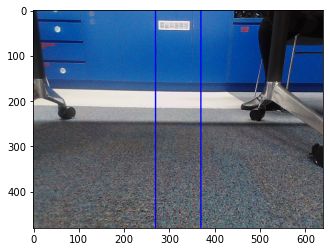

In [ ]:
# Instantiate the TennisBallDetector class
detector = TennisBallDetector()

try:
    while True:
        # Detect tennis balls
        detected = detector.detect()
        
        if detected:
            ball_count = detector.get_ball_count()
            print(f"Detected {ball_count} ball(s).", flush=True)
            
            for i in range(ball_count):
                distance_from_lines = detector.get_ball_distance_from_lines(i)
                y_dist = detector.get_ball_vertical_y(0)
                print(f"Y distance: {y_dist}")
                if distance_from_lines is not None:
                    print(f"Ball {i+1} distance from center lines: {distance_from_lines:.2f} pixels", flush=True)
                else:
                    print(f"Ball {i+1}: Unable to calculate distance from lines.", flush=True)
            
            # Display the resulting frame
            detector.display_frame()
            # display.clear_output(wait=True)
        else:
            display.clear_output(wait=True)
            print("No ball detected.", flush=True)  # Check if no ball is detected
            detector.display_frame()

except KeyboardInterrupt:
    print("Stopping detection.")
finally:
    pass
#     detector.camera.release()
#     cv2.destroyAllWindows()  # Clean up windows if any are open